<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Viz-costs" data-toc-modified-id="Viz-costs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Viz costs</a></span></li><li><span><a href="#Sampling-solutions" data-toc-modified-id="Sampling-solutions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sampling solutions</a></span></li></ul></li><li><span><a href="#Building-the-&quot;grid&quot;" data-toc-modified-id="Building-the-&quot;grid&quot;-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building the "grid"</a></span><ul class="toc-item"><li><span><a href="#analyze-the-ratio-list" data-toc-modified-id="analyze-the-ratio-list-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>analyze the ratio list</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

# Description

Same as the linearcost notebook, except that here we want to run a grid search for several sets of parameters defining the cost functions. 

# Load

The characteristics of the graph are loaded from Excel files. 

In [3]:
edges = pd.read_excel('cost_edges_3.xlsx')
inv_edges = pd.read_excel('inv_demand_3.xlsx')

In [4]:
edges['phi']=3

In [5]:
edges['k']=1

In [6]:
edges

,origin,destination,phi,k
0,1,2,3,1
1,2,1,3,1
2,1,3,3,1
3,3,1,3,1
4,2,3,3,1
5,3,2,3,1


In [9]:
inv_edges['phi']+=1

In [8]:
inv_edges['shift'] = 15

In [20]:
inv_edges['k'] = 1

In [21]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,2,1,15
1,2,1,4,1,15
2,3,1,3,1,15
3,1,3,5,1,15
4,2,3,2,1,15
5,3,2,4,1,15


## Viz costs

Visualize the costs for each OD pair specified in the Excels. 

In [18]:
# inv_edges['shift'] = inv_edges['shift']+15

In [26]:
inv_edges['k'] = .25

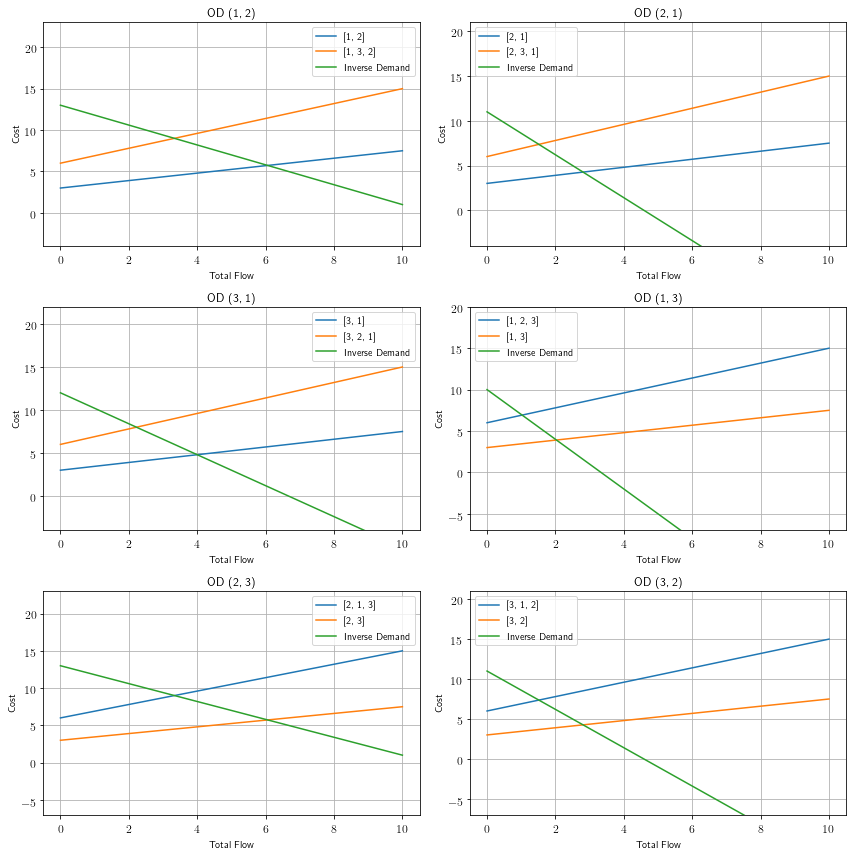

In [27]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

In [28]:
inv_edges['k'] = .5

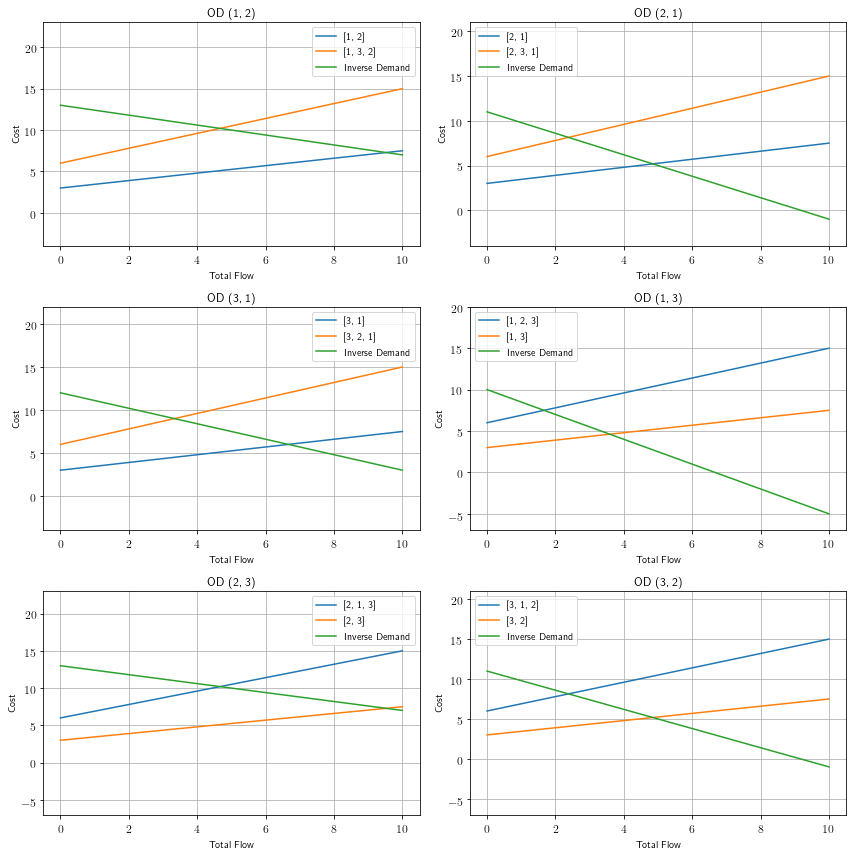

In [29]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

In [30]:
inv_edges['k'] = .75

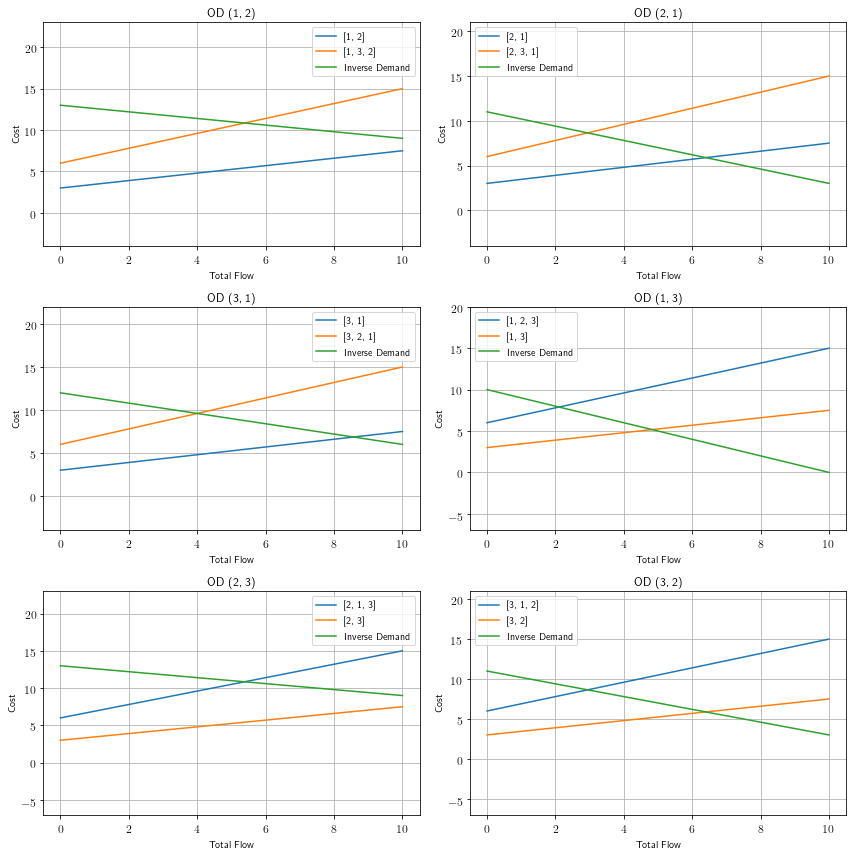

In [31]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

## Sampling solutions

# Building the "grid"

In [35]:
import itertools

In [48]:
max_ratio = []

In [57]:
ratio_list = []

In [58]:
N = 10 #N^2 is the total number of problems to solve

In [59]:
correct = False

In [60]:
for k in itertools.product([.25, .5, .75], repeat = 6):
    inv_edges_crt = inv_edges.copy()
    inv_edges_crt['k'] = k

    f_p, f_r, r, d_var, prob, map_comps, map_edges,\
     costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges_crt, correct = correct, beta = 1)



    r_vec = np.linspace(-10, 10, N)

    _map = []
    _r = []
    for r1 in r_vec:
        for r2 in r_vec:
            r3 = -(r1+r2)
            new_r = [r1, r2, r3]
            _r.append(new_r)
            r.value = new_r
            prob.solve(solver = cp.GUROBI)
            _map.append(get_new_r(f_p, map_edges, nodes))

    ratio_grid = np.zeros((len(_map), len(_map)))
    for i in range(len(_r)):
        for j in range(len(_r)):
            r1 = np.array(_r[i])
            r2 = np.array(_r[j])
            Tr1 = np.array(_map[i])
            Tr2 = np.array(_map[j])
            ratio = np.linalg.norm(Tr1-Tr2)/np.linalg.norm(r1-r2)
            ratio_grid[i,j] = ratio
    ratio_list.append(ratio_grid)

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
len(ratio_list)

729

In [62]:
import pickle
with open('Data/ratio_list.pkl', 'wb') as f:
    pickle.dump(ratio_list, f)

## analyze the ratio list

In [63]:
import pickle
with open('Data/ratio_list.pkl', 'rb') as f:
    ratios = pickle.load(f)

In [67]:
max_vec =[]
for rat in ratios:
    max_vec.append(np.nanmax(rat))

In [68]:
np.max(max_vec)

0.6895483565949635

In [72]:
import seaborn as sns

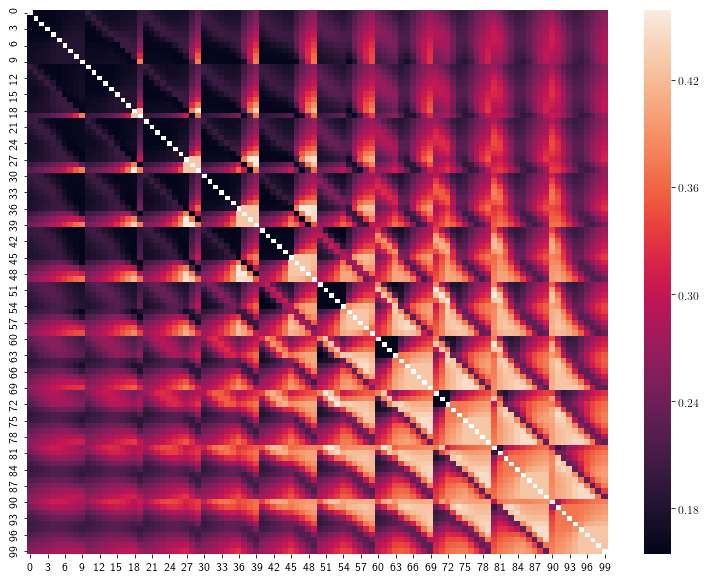

In [73]:
idx = np.random.randint(0, len(ratios))
plt.figure(figsize = (13, 10))
sns.heatmap(ratios[idx])